<a href="https://colab.research.google.com/github/raaraya1/Personal-Proyects/blob/main/Cursos/sklearn/ICA_(Independent_Component_Analysis).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ICA (Independent Component Analysis)**

Fuente: https://towardsdatascience.com/independent-component-analysis-ica-in-python-a0ef0db0955e


ICA es un metodo que se utiliza para identificar las componentes de una señal multivariada. De esta manera es que podemos extraer un componente que se encuentre mezclados con otros.

 - A $X$ restarle su media $\bar{X}$
 - Transformar $X$ de manera que las potenciales correlaciones entre las componentes sea removidas y que la varianza para cada componente sea igual a 1. (Hacer que la matriz de covarianza se paresca a la matriz de identidad)

  $$
  \hat{x} = E \cdot \sqrt{D} \cdot E^{T} \cdot x
  $$

   - $D$: Diagonal con valores propios (de la matriz de covarianzas)
   - $E$: Matrix con vectores propios (de la matriz de covarianzas)

 - Escoger valores aleatorios para armar la matriz $W$.
 - Calcular los nuevos valores para $W$

  $$
  w_{i} = \frac{1}{n} \sum X \cdot tanh(W^{T} \cdot X) - \frac{1}{n} \sum X \cdot (1 - tanh^{2}(W^{T} \cdot X) \cdot W)
  $$

$$
w_{i} = w_{i} - \sum_{j=1}^{p-1} (w_{p}^{T}w_{j})w_{j}
$$

 - Normalizar $w_{p}$

$$
w_{p} = \frac{w_{p}}{||w_{p}||}
$$

 - Chequear condicion de termino. Si no se cumple volvemos a calcular los nuevos valores de $w$
    

$$
w_{p}^{T}w_{p+1} - 1 < Tolerance
$$

 - Calcular la fuentes independientes como $S = W \cdot X$

# **Armando el algoritmo desde cero**

In [4]:
import numpy as np
np.random.seed(0)
from scipy import signal
from scipy.io import wavfile
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [2]:
def g(x):
  return np.tanh(x)

def g_der(x):
  return 1 - g(x)*g(x)

def center(X):
  X = np.array(X)
  mean = X.mean(axis=1, keepdims=True)
  return X - mean

def whitening(X):
  cov = np.cov(X)
  d, E = np.linalg.eigh(cov)
  D = np.diag(d)
  D_inv = np.sqrt(np.linalg.inv(D))
  X_whiten = np.dot(E, np.dot(D_inv, np.dot(E.T, X)))
  return X_whiten

def calculate_new_w(w, X):
  w_new = (X * g(np.dot(w.T, X))).mean(axis=1) - g_der(np.dot(w.T, X)).mean()*w
  w_new = w_new / np.sqrt((w_new**2).sum())
  return w_new

In [3]:
def ica(X, iterations, tolerance=1e-5):
  X = center(X)
  X = whitening(X)
  components_nr = X.shape[0]

  W = np.zeros((components_nr, components_nr), dtype=X.dtype)

  for i in range(components_nr):
    w = np.random.rand(components_nr)
    for j in range(iterations):
      w_new = calculate_new_w(w, X)
      if i >=1:
        w_new -= np.dot(np.dot(w_new, W[:i].T), W[:i])
      distance = np.abs(np.abs((w * w_new).sum() - 1))
      w = w_new
      if distance < tolerance:
        break
    W[i, :] = w
  S = np.dot(W, X)
  return S
    

In [5]:
def plot_mixture_sources_predictions(X, original_sources, S):
    fig = plt.figure()
    plt.subplot(3, 1, 1)
    for x in X:
        plt.plot(x)
    plt.title("mixtures")
    plt.subplot(3, 1, 2)
    for s in original_sources:
        plt.plot(s)
    plt.title("real sources")
    plt.subplot(3,1,3)
    for s in S:
        plt.plot(s)
    plt.title("predicted sources")
    
    fig.tight_layout()
    plt.show()

In [7]:
n_samples = 2000
time = np.linspace(0, 8, n_samples)
s1 = np.sin(2 * time)  # sinusoidal
s2 = np.sign(np.sin(3 * time))  # square signal
s3 = signal.sawtooth(2 * np.pi * time)  # saw tooth signal

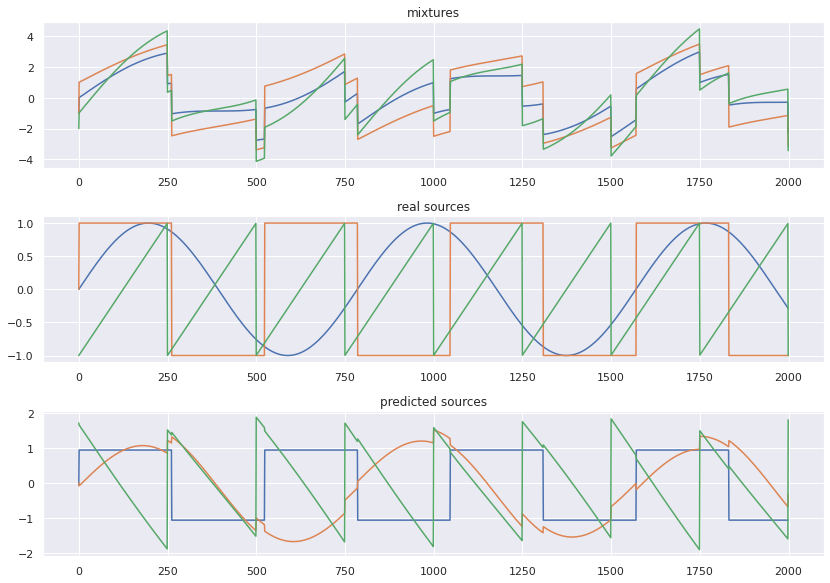

In [8]:
X = np.c_[s1, s2, s3]
A = np.array(([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]]))
X = np.dot(X, A.T)
X = X.T
S = ica(X, iterations=1000)
plot_mixture_sources_predictions(X, [s1, s2, s3], S)

# **Ahora desde sklearn**

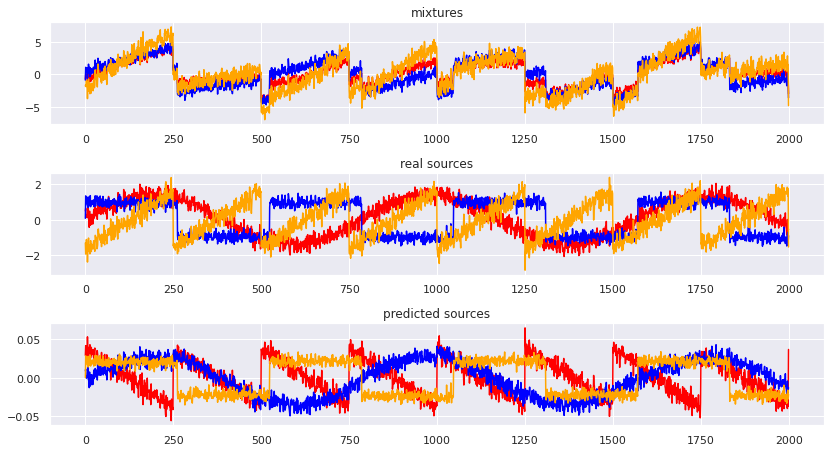

In [10]:
from sklearn.decomposition import FastICA
np.random.seed(0)
n_samples = 2000
time = np.linspace(0, 8, n_samples)
s1 = np.sin(2 * time)
s2 = np.sign(np.sin(3 * time))
s3 = signal.sawtooth(2 * np.pi * time)
S = np.c_[s1, s2, s3]
S += 0.2 * np.random.normal(size=S.shape)
S /= S.std(axis=0)
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])
X = np.dot(S, A.T)
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)
fig = plt.figure()
models = [X, S, S_]
names = ['mixtures', 'real sources', 'predicted sources']
colors = ['red', 'blue', 'orange']
for i, (name, model) in enumerate(zip(names, models)):
    plt.subplot(4, 1, i+1)
    plt.title(name)
    for sig, color in zip (model.T, colors):
        plt.plot(sig, color=color)
        
fig.tight_layout()        
plt.show()